- **Nombre del candidato:** Juan Carlos Salazar Mesa
- **Fecha:** 08/08/2025
- **Email de contacto:** jucasamesa2@gmail.com

# Introducción

El equipo de Moderaciones IT (ModIT) dentro de Mercado Libre, se encarga de bloquear productos del marketplace que infringen políticas como derechos de autor, derechos de marca o aquellos cuyas imágenes no cumplen ciertos estándares de calidad. Estas bajas o moderaciones se pueden realizar manualmente o de forma automática, esta última siempre apoyada por modelos de Machine Learning que toman decisiones con base en los atributos (precio, marca, título, descripción, etc) y/o las imágenes de los productos.

Debido a que Mercado Libre tiene como prioridad en el 2022 el segmento de moda, ModIT está analizando todos los productos nuevos dentro del segmento de moda con el fin de moderar aquellos cuya imagen de portada no presente el producto en un fondo plano en color blanco o crema. Teniendo en cuenta que este trabajo está siendo realizado de forma manual por un equipo de 10 personas (moderadores) el análisis de ítems se limita a un total de 4,000 diarios. 

Ante esto nuestro equipo decide aceptar el reto y disparar un proceso de experimentación para identificar si podríamos o no generar algún recurso que apoye al equipo ModIT para automatizar el proceso y agregar valor a la experiencia laboral de los moderadores. 

A continuación te presentaremos 3 tareas comunes que nos enfrentamos como equipo al momento proponer una solución a algún problema planteado, para resolver cada una de ellas ten en cuenta los siguientes puntos:

1. Siéntete libre de realizar preguntas ante cualquier duda que se te presente. Estamos a un correo de distancia.
2. Los experimentos que realices deben ser replicables. Asegúrate de dejar disponible todo lo necesario para que podamos ejecutar tu código. Puedes usar archivos auxiliares como archivo de dependencias o scripts con funciones o clases.
3. Es importante que documentes lo que más puedas de tu código y dejes plasmado todas las ideas, procesos, experimentos, hipótesis y/o conclusiones que tuviste mientras estabas resolviendo el problema.
4. No esperamos una solución perfecta, para nosotros es más importante el proceso que planteas que el performance de la solución.

Mucha suerte!

# Parte I

Para el proceso de experimentación ModIT nos envía un archivo CSV (`training_data.csv`) con las siguientes columnas:
- **item_id:** Identificador único de item dentro del marketplace.
- **site_id:** País al que pertenece el ítem.
- **domain_id:** Categoría del marketplace a la que pertenece el ítem.
- **picture_id:** Identificador único de la imagen de portada del ítem. Con el *picture_id* podrás construir una url para descargar cada imagen, la estructura es la siguiente: https://http2.mlstatic.com/D_{picture_id}-F.jpg, e.g. http://http2.mlstatic.com/D_680853-MLM50014173158_052022-F.jpg
- **correct_background?:** 1 si el producto se presenta en un fondo apropiado, 0 de lo contrario.

En esta sección se requiere que realices los experimentos necesarios que permitan responder sí podemos o no dar solución al problema. 

## 1. Estado del arte

Antes de realizar la experimentación y determinar si podemos o no ayudar a ModIT. Se realizó una revisión del estado del arte sobre las: 

**Investigaciones sobre Detección Automática de Fondos en Imágenes de Productos para E-commerce**

Las 5 investigaciones más relevantes sobre políticas de calidad para detección de fondos en imágenes de productos han revolucionado la moderación automatizada en plataformas de comercio electrónico. Los avances recientes demuestran que la combinación de modelos fundamentales generalistas con soluciones especializadas comerciales puede lograr precisiones superiores al 90% en la detección y validación de fondos, reduciendo hasta un 70% el tiempo de moderación manual en marketplaces de gran escala.

1. [Caso de Estudio MercadoLibre con Vue.ai (2021)](https://www.vue.ai/blog/ai-in-retail/automated-image-quality-moderation/)
[Autores: Vue.ai Research Team en colaboración con MercadoLibre](https://www.vue.ai/resources/case-studies/automated-image-moderation-for-mercadolibre/)
Año: 2021
Metodología: Implementación de solución de moderación automatizada de imágenes utilizando clasificadores de Redes Neuronales Convolucionales (CNN) con puntuación de confianza (escala 0-1) para decisiones automáticas de aceptación/rechazo. Sistema capaz de procesar 30k solicitudes por minuto.
Logros: 70% de reducción en tasas de rollback durante tres meses, 45% de reducción promedio mensual en tasas de rollback, 30% de reducción en tickets de contacto con proveedores, y 51% de reducción total en contactos durante tres meses.
Disponibilidad de implementación: Sistema de producción implementado en el ecosistema de e-commerce más grande de América Latina (275.4 millones de listados activos). Incluye capacidades de retroalimentación en tiempo real y reentrenamiento continuo de modelos.

2. [Sesgo de Fondo en Aprendizaje Métrico Profundo (2022)](arXiv:2210.01615v1)
Autores: Konstantin Kobs, et al.
Año: 2022
Metodología: Análisis del impacto del fondo en modelos de aprendizaje métrico profundo para recuperación de productos, con integración automática de eliminación de fondos. Estudia el sesgo de fondo en sistemas de recuperación de productos y propone soluciones mediante reemplazo automático de fondos.
Hallazgos clave: Identificación de sesgo significativo de fondo en sistemas de recuperación de productos. Demuestra que el **reemplazo de fondos durante el entrenamiento mejora el rendimiento**. La eliminación automática de fondos reduce el sesgo sin anotación manual adicional.
Disponibilidad de implementación: Utiliza métodos de eliminación automática de fondos para aumentación de datos de entrenamiento. Código y metodología específicos para aplicaciones de recuperación de productos y e-commerce.

3. [Segment Anything Model (SAM) - Meta AI (2023)](https://github.com/facebookresearch/segment-anything) 
Autores: Alexander Kirillov, Eric Mintun, Nikhila Ravi, et al. (Meta AI)
Año: 2023
Metodología: Modelo fundamental para segmentación de imágenes basado en arquitectura Vision Transformer (ViT) con capacidades de segmentación mediante prompts. Incluye tres componentes principales: codificador de imagen, codificador de prompts y decodificador de máscaras.
Logros: El modelo fue entrenado con 1 billón de máscaras en 11 millones de imágenes, logrando rendimiento competitivo con métodos supervisados en escenarios de zero-shot. Su capacidad de generalización permite aplicaciones directas en imágenes de productos sin reentrenamiento específico.
Disponibilidad de implementación: Código completamente abierto disponible en GitHub con múltiples implementaciones específicas para e-commerce. Incluye APIs comerciales y integraciones para plataformas de marketplace.

4. [Impacto de la Eliminación de Fondos en Redes Neuronales para Clasificación de Imágenes de Moda (2023)](https://arxiv.org/abs/2308.09764)
Autores: Junhui Liang, Vladimir Vlassov, et al.
Año: 2023 (actualizado mayo 2024)
Metodología: Evaluación exhaustiva de técnicas de Detección de Objetos Prominentes (SOD) para eliminación de fondos en moda. Utiliza U2Net y otras redes SOD con análisis específico para imágenes de productos textiles con fondos diversos.
Hallazgos clave: Mejora de hasta 5% en precisión en el dataset FashionStyle14 para redes neuronales superficiales. Demuestra que la eliminación de fondos es efectiva para redes simples pero presenta incompatibilidades con técnicas de regularización de aprendizaje profundo. Utilizaron [rembg].(https://github.com/danielgatis/rembg)
Disponibilidad de implementación: Detalles completos de implementación proporcionados utilizando U2Net. Dataset FashionStyle14 con 2,616 imágenes anotadas disponible para replicación de resultados.

5. [BRIA AI RMBG Models v2.0 (2024)](https://huggingface.co/spaces/briaai/BRIA-RMBG-2.0)
Autores: BRIA AI Research Team
Año: 2024
Metodología: Construido sobre la arquitectura BiRefNet (Bilateral Reference Network) con esquema de entrenamiento propietario. Utiliza 15,000+ imágenes de alta resolución con licencias legales, incluyendo productos comerciales, personas con objetos y demografías equilibradas.
Hallazgos clave: RMBG v2.0 alcanza 90% de precisión en benchmarks comerciales, superando significativamente a Adobe Photoshop (46%) y rivalizando con remove.bg (97%). Procesamiento en tiempo real con capacidades de producción industrial.
Disponibilidad de implementación: Modelos disponibles en Hugging Face con licencias comerciales. Específicamente diseñado para aplicaciones de e-commerce, gaming y publicidad con datos de entrenamiento de calidad profesional.

**Conclusiones técnicas**
La investigación demuestra una madurez técnica significativa en sistemas automatizados de control de calidad y validación de imágenes para marketplaces de e-commerce desde 2022-2025. Los enfoques basados en aprendizaje profundo, particularmente arquitecturas CNN y ResNet, han alcanzado rendimiento listo para producción con mejoras documentadas del 70% en eficiencia de procesamiento y incrementos del 30% en tasas de conversión.
Las implementaciones más exitosas combinan modelos fundamentales generalistas como SAM para flexibilidad investigativa con modelos comerciales especializados como BRIA RMBG para despliegues de producción que requieren alta precisión y cumplimiento legal. Esta estrategia híbrida permite optimizar tanto la investigación académica como las aplicaciones comerciales inmediatas.

Dado qué en el pasado MELI contrato a Vue.ai para la moderación de imágenes y teniendo en cuenta los avances en segmentación de imágenes y remoción de fondos. Se puede concluir que sí es posible ayudar a ModIT a dar solución al problema. 

Para ello lo primero es extraer las imágenes del archivo `data/training_data.csv`, para lo cuál se creo el flujo `image_downloader.py` el cuál descarga las imágenes en un directorio seleccionado, para este caso en `data/images` y crea un resumen en `data/downloaded_images_dataset.csv`.

### Ambiente de programacion

In [79]:
# system
import sys
from pathlib import Path
sys.path.append("../")

# operaciones matriciales / data
import colour
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)

from tqdm import tqdm

# manejo de imagenes
import cv2 # opencv 
from PIL import Image

# visualizacion
import seaborn as sns
import matplotlib.pyplot as plt

# eda
from analyze_background_colors import explore_color_ranges
from eda_modules.image_analyzer import ImageAnalyzer

# modelado
from sklearn.metrics import f1_score


## 2. EDA
A continuación una revisión de las imágenes:

In [81]:
# Path inicial a proyecto
project_root = Path("../")

In [ ]:
# Cargar dataset de imagenes descargadas
train_csv_path = Path("../data/train_images_dataset.csv")

train = pd.read_csv(train_csv_path)
train.shape

(4372, 11)

In [27]:
train.sample(2)

,item_id,site_id,domain_id,picture_id,correct_background?,image_url,local_path,filename,download_success,error_message,file_exists
612,MLB2619470880,MLB,MLB-T_SHIRTS,619717-CBT49728894105_042022,1,https://http2.mlstatic.com/D_619717-CBT4972889...,data\images\MLB2619470880_619717-CBT4972889410...,MLB2619470880_619717-CBT49728894105_042022.jpg,True,NaN,False
65,MLM1455409106,MLM,MLM-JACKETS_AND_COATS,663470-CBT50637652840_072022,0,https://http2.mlstatic.com/D_663470-CBT5063765...,data\images\MLM1455409106_663470-CBT5063765284...,MLM1455409106_663470-CBT50637652840_072022.jpg,True,NaN,False


In [ ]:
# Revision del tipo de ropa
train['domain_id'].str.split("-").str[1].value_counts()

domain_id
JACKETS_AND_COATS                   827
T_SHIRTS                            821
SNEAKERS                            703
PANTS                               339
SWEATSHIRTS_AND_HOODIES             244
SHIRTS                              200
BOOTS_AND_BOOTIES                   196
LOAFERS_AND_OXFORDS                 195
BLOUSES                             182
SHORTS                              128
HEELS_AND_WEDGES                    123
SWEATERS_AND_CARDIGANS               95
AUTOMOTIVE_SKIRTS                    69
LEGGINGS                             56
SWIMWEAR                             44
SPORT_T_SHIRTS                       36
FOOTBALL_SHOES                       25
SPORT_SHORTS                         19
SPORT_PANTS                          16
UNDERPANTS                           15
PET_JACKETS_AND_COATS                 9
BABY_SWIMWEAR                         6
MOTORCYCLE_PANTS                      6
FISHING_SHIRTS                        6
SPORT_SWIMWEAR                

In [ ]:
# Crear la instancia para manejar imagenes proveniente de eda.modules
analyzer = ImageAnalyzer()
# Crear lista donde se guardaran los df
df_list = []
# Iterar en cada fila y analizar cada imagen
for idx, row in tqdm(train.iterrows()):

    local_df = pd.DataFrame(analyzer.analyze_single_image(project_root / row['local_path']), index=[idx])
    df_list.append(local_df)
    
# Concatenar df de data de imagenes
train_data = pd.concat(df_list)
train_data.shape

4372it [59:29,  1.22it/s]


(4372, 28)

In [60]:
train.head(1)

,item_id,site_id,domain_id,picture_id,correct_background?,image_url,local_path,filename,download_success,error_message,file_exists
0,MLA1133559288,MLA,MLA-PANTS,727367-MLA49747205451_042022,0,https://http2.mlstatic.com/D_727367-MLA4974720...,data\images\MLA1133559288_727367-MLA4974720545...,MLA1133559288_727367-MLA49747205451_042022.jpg,True,NaN,True


In [ ]:
# Guardar propiedades extraidas en los csv
train.merge(train_data.rename(columns={'image_name':'filename'}), how='left', on='filename')\
    .to_csv(train_csv_path, index=False)

In [51]:
# Cargar dataset de imagenes descargadas
val_csv_path = Path("../data/productive_images_dataset.csv")

val = pd.read_csv(val_csv_path)
val.shape

(1627, 11)

In [52]:
# Crear lista donde se guardaran los df
df_list = []
# Iterar en cada fila y analizar cada imagen
for idx, row in tqdm(val.iterrows()):

    local_df = pd.DataFrame(analyzer.analyze_single_image(project_root / row['local_path']), index=[idx])
    df_list.append(local_df)
    
# Concatenar df de data de imagenes
val_data = pd.concat(df_list)
val_data.shape

1627it [21:04,  1.29it/s]


(1627, 28)

In [66]:
val.merge(val_data.rename(columns={'image_name':'filename'}), how='left', on='filename')\
    .to_csv(val_csv_path, index=False)

### Datasets de imágenes caracterizadas

In [38]:
# Cargar dataset de imagenes descargadas
train_csv_path = Path("../data/train_images_dataset.csv")

train = pd.read_csv(train_csv_path)
train.shape

(4372, 38)

In [39]:
# Cargar dataset de imagenes descargadas
val_csv_path = Path("../data/productive_images_dataset.csv")

val = pd.read_csv(val_csv_path)
val.shape

(1627, 38)

In [40]:
train.sample(1)

,item_id,site_id,domain_id,picture_id,correct_background?,image_url,local_path,filename,download_success,error_message,file_exists,image_path,width,height,aspect_ratio,total_pixels,brightness,contrast,entropy,sharpness,noise_level,saturation,value,background_ratio,object_ratio,dominant_color_r,dominant_color_g,dominant_color_b,dominant_color_h,dominant_color_s,dominant_color_v,edge_density,contour_count,texture_contrast,texture_dissimilarity,texture_homogeneity,texture_energy,texture_correlation
75,MLB2221338114,MLB,MLB-BOOTS_AND_BOOTIES,744637-MLB43638411337_092020,?,https://http2.mlstatic.com/D_744637-MLB4363841...,data\images\MLB2221338114_744637-MLB4363841133...,MLB2221338114_744637-MLB43638411337_092020.jpg,True,NaN,False,..\data\images\MLB2221338114_744637-MLB4363841...,932,964,0.966805,898448,144.682527,109.441995,4.74724,399.269792,2.116713,14.371703,145.698448,1.0,0.0,253.525,253.353,253.303,0,0,253,0.0,0,1391.054698,12.037506,0.515782,0.379902,0.941818


### **Caracteristicas extraídas relacionadas a los fondos**

- **`dominant_color_r`, `dominant_color_g`, `dominant_color_b`**:  
  - Miden directamente los valores RGB del color dominante del fondo.  
  - **¿Por qué?** El blanco puro tiene valores altos en todos los canales (ej. `[255, 255, 255]`), mientras que el crema tiene valores ligeramente más bajos en rojo/verde y más altos en azul (ej. `[255, 253, 208]`).  

- **`dominant_color_h`, `dominant_color_s`, `dominant_color_v`**:  
  - Los valores HSV aíslan mejor el tono (H) y la saturación (S). El crema tiene un tono amarillo sutil (`H ≈ 50–60°`) y menor saturación que el blanco puro (`S=0`).  

- **`saturation`**:  
  - El crema tiene saturación leve (por su tinte amarillo), mientras que el blanco no tiene ninguna (`S ≈ 0`).  

- **`value` (brillo en HSV)**:  
  - Ambos son claros, pero el crema es ligeramente menos brillante (`V ≈ 90–95%` vs. `100%` del blanco).  

- **`brightness`**:  
  - Intensidad promedio de los píxeles. El crema y el blanco son los más brillantes.  
- **`contrast`**:  
  - Los fondos blancos suelen ser más uniformes (bajo contraste), mientras que el crema puede tener variaciones sutiles.  

Hipótesis de características posiblemente relacionadas a la clasificación de fondos para el control de calidad:
- **color (RGB/HSV)**, **brillo** y **saturación** más relacionadas.
- Características de textura pueden aportar mejoras marginales.
- Ignora características estructurales.

In [44]:
train[['brightness', 'contrast', 'entropy', 'sharpness', 'noise_level', 'saturation', 'value',
       'dominant_color_r', 'dominant_color_g', 'dominant_color_b', 'dominant_color_h', 'dominant_color_s',
       'dominant_color_v']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
brightness,4372.0,150.960095,39.709677,31.133792,122.495720,147.121726,178.727960,250.921158
contrast,4372.0,71.976753,22.716959,12.573657,54.928543,71.173365,91.134351,122.330392
entropy,4372.0,5.990930,1.336119,1.091610,4.865440,6.255420,7.196612,7.985520
sharpness,4372.0,805.371253,1239.789758,4.806000,187.690869,418.947591,896.319813,22117.667407
noise_level,4372.0,3.112011,2.389788,0.241101,1.576783,2.461526,3.856522,23.638951
saturation,4372.0,50.891075,37.670974,0.000000,21.628282,42.825236,71.229240,243.856577
value,4372.0,164.523793,38.719816,38.672092,137.114555,161.746900,192.366999,252.758861
dominant_color_r,4372.0,170.922740,86.371809,0.144654,78.311375,203.357500,251.624250,255.873000
dominant_color_g,4372.0,163.283271,89.238445,0.188243,62.581975,194.065000,251.233750,255.872000
dominant_color_b,4372.0,162.143007,88.945790,0.197340,65.043700,187.539500,251.366750,255.875000


In [64]:
train['calidad'] =  train['correct_background?']
val['calidad'] =  val['correct_background?']

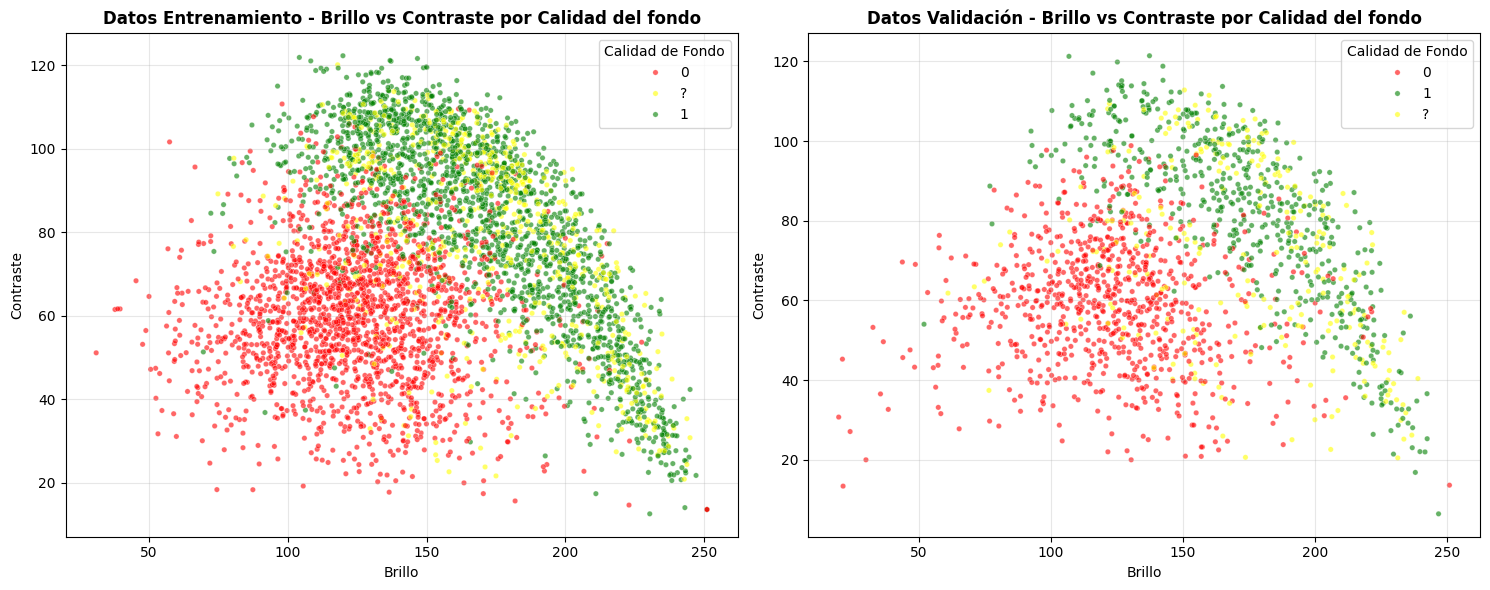

In [ ]:
# Define fixed colors for consistency
color_palette = {
    '0': 'red',
    '1': 'green',
    '?': 'yellow',
}

# Create subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - Training data
sns.scatterplot(
    data=train,
    x='brightness',
    y='contrast',
    hue='calidad',
    alpha=0.6,
    s=15,
    ax=ax1,
    palette=color_palette
)

ax1.set_title('Datos Entrenamiento - Brillo vs Contraste por Calidad del fondo', fontweight='bold')
ax1.set_xlabel('Brillo')
ax1.set_ylabel('Contraste')
ax1.grid(True, alpha=0.3)
ax1.legend(title='Calidad de Fondo')

# Second subplot - Validation data
sns.scatterplot(
    data=val,
    x='brightness',
    y='contrast',
    hue='calidad',
    alpha=0.6,
    s=15,
    ax=ax2,
    palette=color_palette
)

ax2.set_title('Datos Validación - Brillo vs Contraste por Calidad del fondo', fontweight='bold')
ax2.set_xlabel('Brillo')
ax2.set_ylabel('Contraste')
ax2.grid(True, alpha=0.3)
ax2.legend(title='Calidad de Fondo')

# Adjust layout
plt.tight_layout()
plt.show()

Claramente se ven dos grupos donde las imágenes con más brillo y más contraste cumplen el control de calidad. Por su parte la característica `?` que se asume como que los moderadores no identificaron o consideran que puede que cumpla se ve esparcida en toda la data aunque tiene un poco más a la región verde.

In [62]:
# Add dataset identifier to distinguish between train and val
train['dataset'] = 'Training'
val['dataset'] = 'Validation'

# Combine datasets
combined_data = pd.concat([train, val], ignore_index=True)
combined_data['calidad'] =  combined_data['correct_background?']

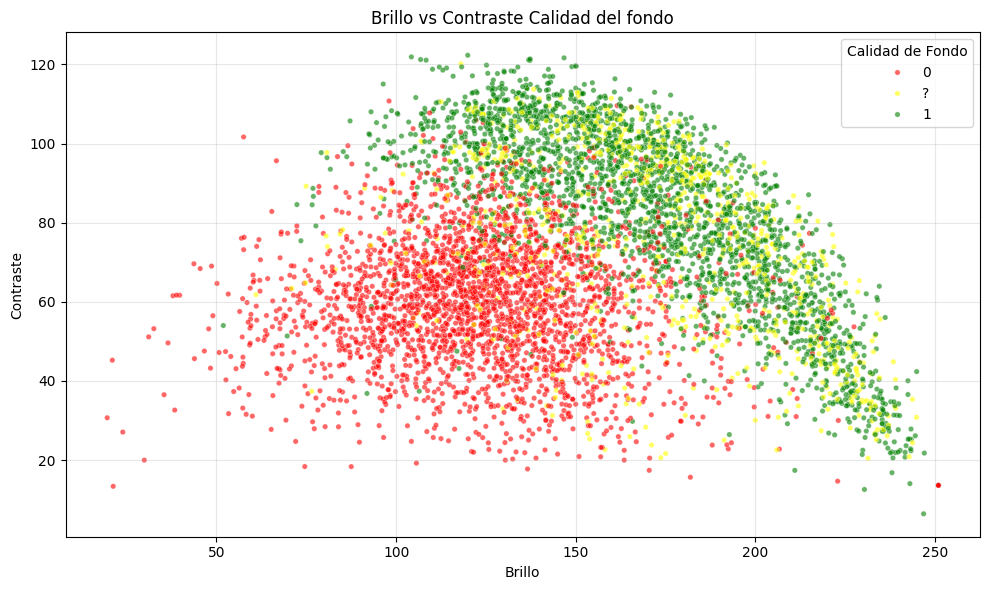

In [68]:
# Create the plot
plt.figure(figsize=(10, 6))

# Simple scatter plot with hue
sns.scatterplot(
    data=combined_data,
    x='brightness',
    y='contrast',
    hue='calidad',
    alpha=0.6,
    s=15,
    palette=color_palette
)

plt.title('Brillo vs Contraste Calidad del fondo')
plt.xlabel('Brillo')
plt.ylabel('Contraste')
plt.grid(True, alpha=0.3)
plt.legend(title='Calidad de Fondo')

plt.tight_layout()
plt.show()

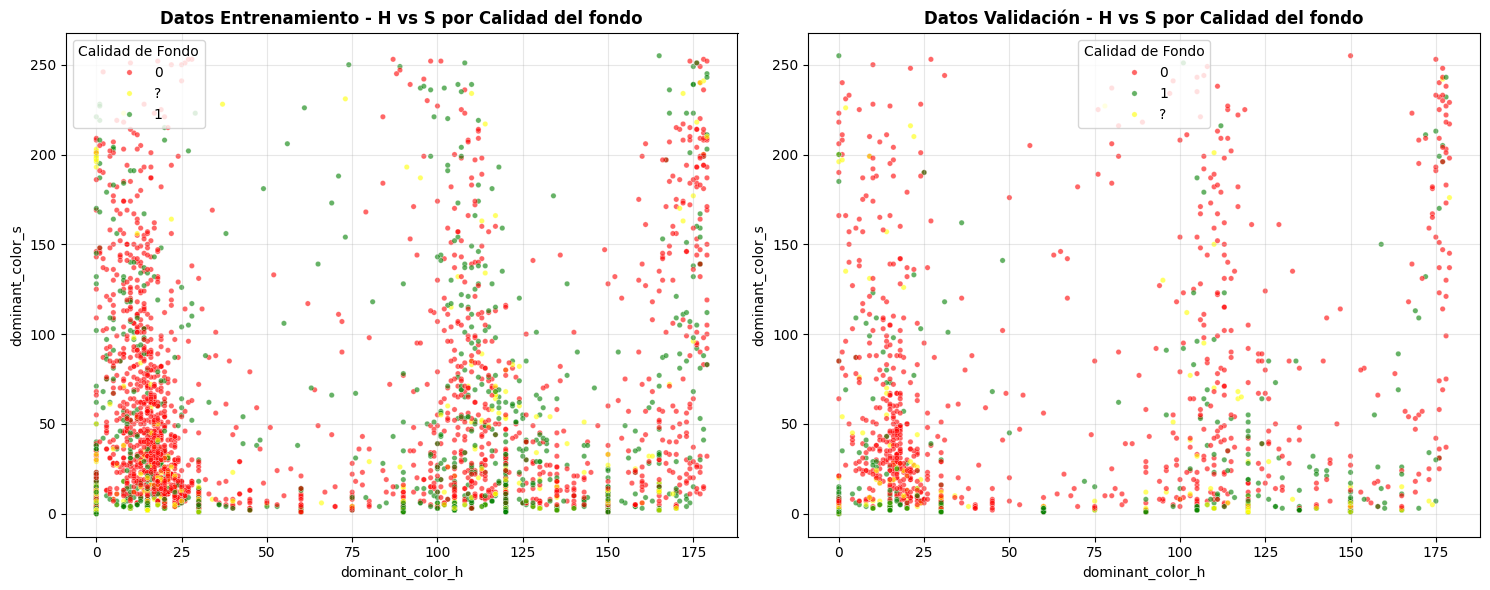

In [70]:
# Create subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - Training data
sns.scatterplot(
    data=train,
    x='dominant_color_h',
    y='dominant_color_s',
    hue='calidad',
    alpha=0.6,
    s=15,
    ax=ax1,
    palette=color_palette
)

ax1.set_title('Datos Entrenamiento - H vs S por Calidad del fondo', fontweight='bold')
ax1.set_xlabel('dominant_color_h')
ax1.set_ylabel('dominant_color_s')
ax1.grid(True, alpha=0.3)
ax1.legend(title='Calidad de Fondo')

# Second subplot - Validation data
sns.scatterplot(
    data=val,
    x='dominant_color_h',
    y='dominant_color_s',
    hue='calidad',
    alpha=0.6,
    s=15,
    ax=ax2,
    palette=color_palette
)

ax2.set_title('Datos Validación - H vs S por Calidad del fondo', fontweight='bold')
ax2.set_xlabel('dominant_color_h')
ax2.set_ylabel('dominant_color_s')
ax2.grid(True, alpha=0.3)
ax2.legend(title='Calidad de Fondo')

# Adjust layout
plt.tight_layout()
plt.show()


Mientras que el color dominante para Hue y Saturación no muestran una clara formación de grupos frente a la variable objetivo.

### Size

In [20]:
print("Ancho promedio de imagenes")
print(train['width'].mean(),val['width'].mean())
print("Alto promedio de imagenes")
print(train['height'].mean(), val['height'].mean()) 

Ancho promedio de imagenes
862.011436414 868.254456054
Alto promedio de imagenes
944.898902104 942.169022741


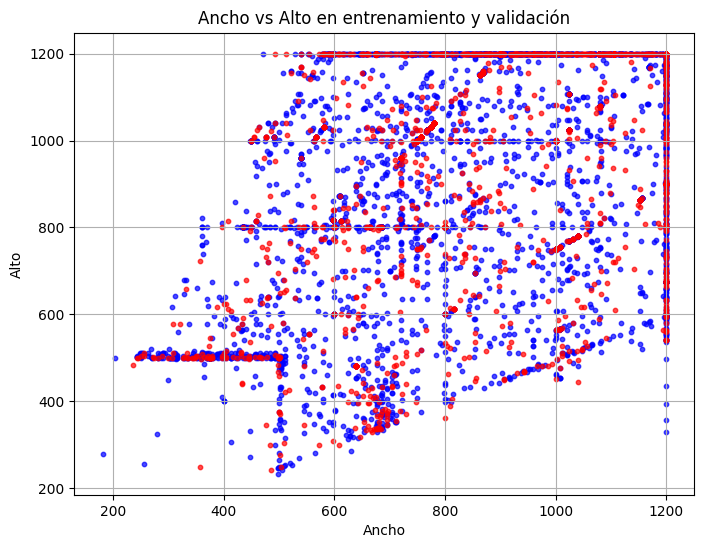

In [76]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(train['width'], train['height'], color='blue', alpha=0.7, s=10)
plt.scatter(val['width'], val['height'], color='red', alpha=0.7, s=10)

# Add labels and title
plt.xlabel('Ancho')
plt.ylabel('Alto')
plt.title('Ancho vs Alto en entrenamiento y validación')
plt.grid(True)

# Show plot
plt.show()

Como se ve en los promedios cálculados y la anterior gráfica, las imágenes de entrenamiento y de validación/producción tienen tamaños similares.

Sabemos que para modelar debemos procesar las imágenes en mismos tamaños ya que los modelos aplican operaciones matriciales y al ser de diferentes tamaños los arrays o tensores, se generará error. Por lo tanto se deben ajustar las imágenes.

Para ello se utiliza el `image_bg_extraction.py` el cuál ejecutá dos procesos principales. El primero es que modifica las imágenes a 512x512 y lo segundo es que aplica rembg, remoción de fondo (método altamente utilizado en la investigación realizada).

1. rembg crea una máscara que identifica el objeto en primer plano (foreground).
2. El script invierte la máscara para obtener las áreas del fondo (background).
3. El script aplica la máscara del fondo al canal alfa, haciendo que el fondo sea transparente y de esta forma no afecte analisis de color.
4. Resultado: El objeto en primer plano sigue ahí, pero ahora es invisible (transparente).
5. Cuando se visualiza: Las áreas transparentes pueden verse negras, como el objeto original o blancas, dependiendo del visor.

Este flujo .py generá tres archivos:
- Análisis de color de fondos guardado en: {actual_output_data_dir}/background_masks_data.csv"
- Arrays completos de las imágenes procesadas: {actual_output_data_dir}/background_masks_arrays.npz"
- Array de mapeo de referencia: {actual_output_data_dir}/mask_arrays_mapping.csv"

### ¿Por qué ajuste a 512x512?

- Más cercano a los promedios de las imágenes.
- Eficiencia de memoria frente a 1024x1024, 2da resolución más cercana a los promedios.
- Buena resolución para detección de fondos mientras se mantiene un costo computacional razonable.
- Es un Estandar común en la industria. 

| Size | Pixels | Features | Memory (MB)* | Training Time |
| --- | --- | --- | --- | --- |
| 256x256 | 65,536 | 65K | ~0.5 | Fast |
| **512x512** | **262,144** | **262K** | **~2** | **Balanced** |
| 1024x1024 | 1,048,576 | 1M | ~8 | Slow |
| 2048x2048 | 4,194,304 | 4M | ~32 | Very Slow |

A continuación, se muestran ejemplos de la imagen original y la imágen procesada:

In [77]:
train_processed_csv_path = Path("../data/train_processed/background_masks_data_with_labels.csv")
train_processed = pd.read_csv(train_processed_csv_path)

val_processed_csv_path = Path("../data/val_processed/background_masks_data_with_labels.csv")
val_processed = pd.read_csv(val_processed_csv_path)

train_processed.shape, val_processed.shape

((3702, 49), (1378, 49))

La disminución en los datos se debe a un filtro que remueve los datos relacionados con la variable objetivo `?`. Ya que como se menciona prviamente se considera como puede que cumpla o no calificada por el moderador, pero claramente se podría utilizar en un modelo de predicción pero ya no de 2 sino de 3 posibles grupos. Por simplicidad y tiempo se tomarán solo los grupos Cumple o No cumple.

In [85]:
train_processed.head(1)

,original_image_name,processed_image_name,mask_height,mask_width,mask_mean,mask_std,mask_min,mask_max,background_pixels,total_pixels,avg_background_r,avg_background_g,avg_background_b,is_white_background,is_cream_background,original_width,original_height,resized_width,resized_height,final_width,final_height,correct_background?,image_path,image_name,width,height,aspect_ratio,brightness,contrast,entropy,sharpness,noise_level,saturation,value,background_ratio,object_ratio,dominant_color_r,dominant_color_g,dominant_color_b,dominant_color_h,dominant_color_s,dominant_color_v,edge_density,contour_count,texture_contrast,texture_dissimilarity,texture_homogeneity,texture_energy,texture_correlation
0,MLA1139536620_641166-MLA49521800644_032022.jpg,background_extracted_MLA1139536620_641166-MLA4...,512,512,168.722187,115.814761,0,255,175066,262144,227.931237,217.56128,210.905167,False,False,490,1008,248,512,512,512,0,data\train_processed_images\background_extract...,background_extracted_MLA1139536620_641166-MLA4...,512,512,1.0,172.839108,95.072351,4.593458,566.801223,2.514126,54.001617,183.750206,1.0,0.0,252.66762,251.8464,249.21054,20,3,252,0.0,0,1166.269143,12.080877,0.558147,0.498031,0.935464


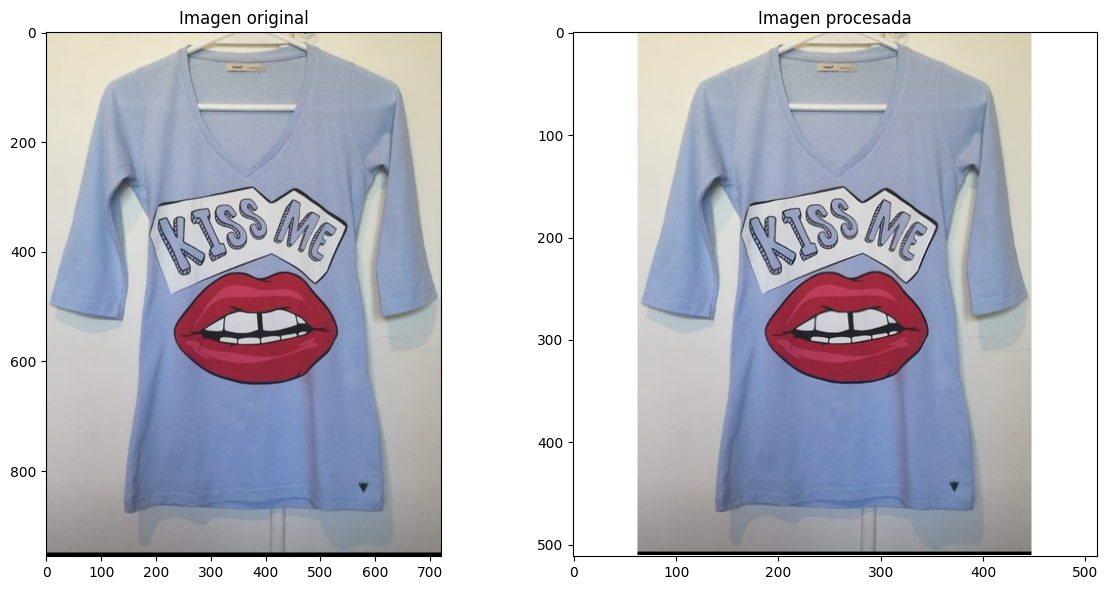

In [ ]:
# Images path
in_img_path = project_root / "data/images" / train_processed['original_image_name'][train_processed.sample(1, random_state=50).index[0]]
out_img_path = project_root / train_processed['image_path'][train_processed.sample(1, random_state=50).index[0]]

# Create subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Read images
in_img = cv2.imread(in_img_path)
out_img = cv2.imread(out_img_path)

# Convert BGR to RGB (OpenCV uses BGR by default, matplotlib uses RGB)
in_img_rgb = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)
out_img_rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

# Display images on the correct axes
ax1.imshow(in_img_rgb)
ax1.set_title('Imagen original')

ax2.imshow(out_img_rgb)
ax2.set_title('Imagen procesada')

# Adjust layout
plt.tight_layout()
plt.show()

### Threshold de color

Ya que el ejercicio de control de calidad de las imágenes requiere color blanco o crema, se debía definir hasta que rango RGB un color se considera crema. Para ello se encontró que existe la "Comisión Internationale de L’Eclairage" o comisión internacional de la iluminación, que actualmente utiliza la convension **LAB** donde **L** es claridad/oscuridad, **A** es intensidad de rojo-verde y **B** es intensidad amarillo-azul.

Para detectar el color crema CIE LAB ofrece las siguientes ventajas:

- Uniformidad Perceptual: Las distancias en CIELAB se correlacionan con las diferencias de color percibidas por el ojo humano.

- Separación de Claridad (L*): El componente L* representa directamente la claridad (85-95 para el crema).

- Componentes de Color:
    - **a** (Rojo-Verde): 0-5 (tonalidades ligeramente cálidas/amarillentas).
    - **b** (Amarillo-Azul): 10-20 (tinte amarillo perceptible).

- Alineación con la Visión Humana: Diseñado para reflejar cómo percibimos los colores, lo que lo hace ideal para aplicaciones donde la precisión visual es clave (ej. diseño, alimentos, textiles).

A continuación se gráfican los límites del color crema y el punto rojo que representa dónde se ubica el color blanco pero en la representación CIE 1976 ya que al ser 2D a diferencia de CIE LAB se peude ver más claro el umbral seleccionado.

<Figure size 1000x700 with 0 Axes>

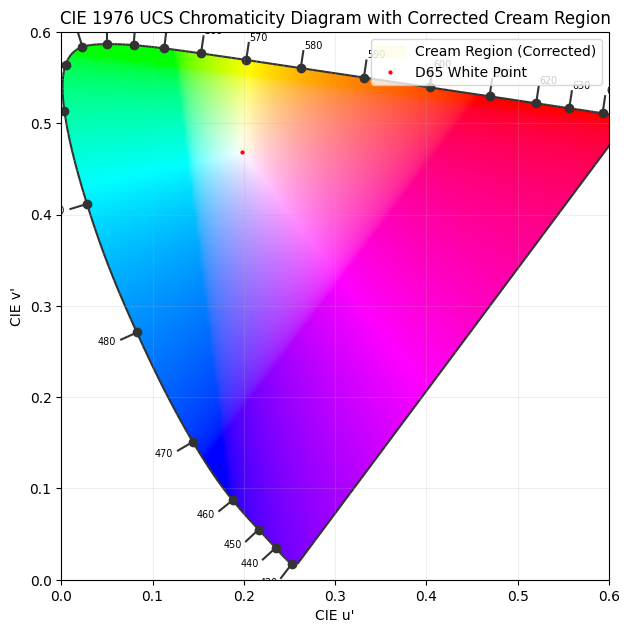

In [30]:
# Define cream thresholds in CIE 1976 UCS (u', v') - CORRECTED
cream_u_min, cream_u_max = 0.197, 0.21  # Based on actual cream colors
cream_v_min, cream_v_max = 0.468, 0.48  # Based on actual cream colors

# Create figure
plt.figure(figsize=(10, 7))
colour.plotting.plot_chromaticity_diagram_CIE1976UCS(show=False)

# Draw cream region as a polygon
cream_vertices = np.array([
    [cream_u_min, cream_v_min],
    [cream_u_min, cream_v_max],
    [cream_u_max, cream_v_max],
    [cream_u_max, cream_v_min]
])
plt.fill(
    cream_vertices[:, 0], cream_vertices[:, 1],
    color='#FFFDD0', alpha=0.4, label='Cream Region (Corrected)'
)

# Mark the white point (D65) in CIE 1976 UCS
uv_D65 = [0.1978, 0.4683]
plt.plot(uv_D65[0], uv_D65[1], 'ro', markersize=2, label='D65 White Point')

plt.title('CIE 1976 UCS Chromaticity Diagram with Corrected Cream Region')
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.xlim(0,0.6)
plt.ylim(0,0.6)
plt.show()

## 3. Modelado

Se utilizaron varios modelos, a los cuales se les aplico Cross Validation para asegurar que el resultado del modelo no dependiera del `train test split` y GridSearch para tunning de características.

- Regresión logística (LR):

Modelo benchmark, ya que tiene las ventajas de ser simple de usar, rápido, requiere pocos hyperpárametros a la hora de `tunning`, trabaja bien con datasets pequeños (se considera pequeño ~4.000 imágenes), es fácil de interpretar, consume poca CPU (no necesita GPU) y permite estimar uncertainty (eg. 80% de prob que esto sea X clase).

Desventajas: Generalmente no se desempeña tan bien, dificultad en problemas no lineales, no es escalable a imágenes de alta resolución, para predicir más de 1 clase requiere extensiones (eg. One vs Rest) y puede reducir precisión.

- Clasificador de vectores de soporte (SVC):

Ventajas: Bueno con datasets pequeños, con buena regularización es fuerte contra el Overfit, efectivo en espacio de muchas dimensiones, tiene múltiples kernels para tratar casos No lineales, menor consumo que redes neuronales.

Desventajas: No escala bien, se dificulta con datasets grandes (en las pruebas realizadas se quedó muchas veces en el procesamiento), no ideal para jeraarquías espaciales complejas.

- Clasificador de Bosques Aleatorios (Random Forest):

Bueno manejando data tabular, como la extraida utilizando el ImageAnalyzer del modulo de eda, bueno para conjuntos de datos pequeños, permiten 
entender que características afectan más al modelo, permiten clasifiación multiclase.

Desventajas: Píxeles sin procesar no pueden ser alimentados, RF no captura relaciones espaciales como las CNN. No recomendado para detección de 
objetos y segmentación, por lo cuál es bueno que hayamos procesado las imágenes para solo evaluar el Background.

- Redes Neuronales Convolucionales (CNN):

Una convolución es una operación matricial que extrae un filtro de una característica específica (bordes, texturas, patrones, etc) 

Ventajas sobre los modelos anteriores:
1. Reconocimiento de patrones espaciales: Aprende relaciones espaciales en imágenes.
2. Mejor generalización: Invariante a traslaciones y robusto frente a variaciones.
3. Aprendizaje automático de características: No requiere ingeniería manual de features.
4. Mayor precisión: Supera expectativas frente a modelos tradicionales de Machine Learning.
5. Especializado en imágenes: Diseñado específicamente para predicción de calidad de fondos basada en imágenes.

### Sin modelo:

Adicional a los modelos mencionados anteriormente esta la predicción solo con el procesamiento de la data y verificación si es un color promedio crema o blanco.

In [32]:
train.sample(2)

,original_image_name,processed_image_name,mask_height,mask_width,mask_mean,mask_std,mask_min,mask_max,background_pixels,total_pixels,avg_background_r,avg_background_g,avg_background_b,is_white_background,is_cream_background,original_width,original_height,resized_width,resized_height,final_width,final_height,correct_background?
867,MLM1381640059_788297-MLM49163870427_022022.jpg,background_extracted_MLM1381640059_788297-MLM4...,512,512,142.469276,125.569032,0,255,146181,262144,254.612850,254.629165,254.610982,True,False,541,457,512,432,512,512,1
2080,MLA1133847136_991914-MLA49764678553_042022.jpg,background_extracted_MLA1133847136_991914-MLA4...,512,512,91.116482,120.519385,0,255,93041,262144,237.830849,233.302716,225.839856,False,False,953,1200,406,512,512,512,0


In [11]:
train[['is_white_background','is_cream_background']].value_counts()

is_white_background  is_cream_background
False                False                  1841
True                 False                  1831
False                True                     30
Name: count, dtype: int64

In [12]:
train['predicted_background'] = (train['is_white_background']|train['is_cream_background']).map({True:1,False:0})

In [13]:
train[['correct_background?','predicted_background']].value_counts()

correct_background?  predicted_background
1                    1                       1727
0                    0                       1705
1                    0                        136
0                    1                        134
Name: count, dtype: int64

In [14]:
f1_score(train['correct_background?'], train['predicted_background'], average='micro')

0.9270664505672609

In [43]:
stats = explore_color_ranges(train)


🔬 Color Range Exploration:
Red channel statistics:
  Mean: 203.0, Std: 58.7
  Min: 1.0, Max: 255.0
  75th percentile: 254.4, 90th percentile: 254.7

Green channel statistics:
  Mean: 196.4, Std: 64.2
  Min: 0.7, Max: 255.0
  75th percentile: 254.4, 90th percentile: 254.7

Blue channel statistics:
  Mean: 191.0, Std: 69.2
  Min: 0.8, Max: 255.0
  75th percentile: 254.2, 90th percentile: 254.7

📊 Potentially light backgrounds (RGB > 200): 1935 (52.7%)

Top 10 lightest backgrounds:
  MLM1403067937_733341-MLM49613568962_042022.jpg: RGB(255, 255, 255)
  MLB2630458014_643810-MLB49839261285_052022.jpg: RGB(255, 255, 255)
  MLB2700174654_742825-MLB50532939351_062022.jpg: RGB(255, 255, 255)
  MLM1399088655_654983-MLM49526282274_032022.jpg: RGB(255, 255, 255)
  MLB2681170697_939953-MLB50331809478_062022.jpg: RGB(255, 255, 255)
  MLB2174260722_706269-CBT49082169652_022022.jpg: RGB(255, 255, 255)
  MLB2638795388_801230-MLB49920641672_052022.jpg: RGB(255, 255, 255)
  MLM1445535781_978602-MLM497545

In [15]:
array = load_image(image_path)

In [16]:
# Get array dimensions
height, width = array.shape[:2]
total_pixels = height * width

# Analyze different regions of the array (center, corners, edges)
regions = {
    'center': array[height//4:3*height//4, width//4:3*width//4],
    'top_left': array[:height//3, :width//3],
    'top_right': array[:height//3, 2*width//3:],
    'bottom_left': array[2*height//3:, :width//3],
    'bottom_right': array[2*height//3:, 2*width//3:]
    }

In [17]:
array.shape

(269, 536, 3)

In [18]:
height, width, total_pixels

(269, 536, 144184)

In [29]:
regions['center'].shape, regions['top_left'].shape

((252, 122, 3), (167, 81, 3))

In [8]:
df['array'] = df['img_path'].apply(load_image)

In [9]:
df['height'] = df['array'].apply(lambda x: x.shape[0])
df['width'] = df['array'].apply(lambda x: x.shape[1])
df['total_pixels'] = df['height']+df['width']

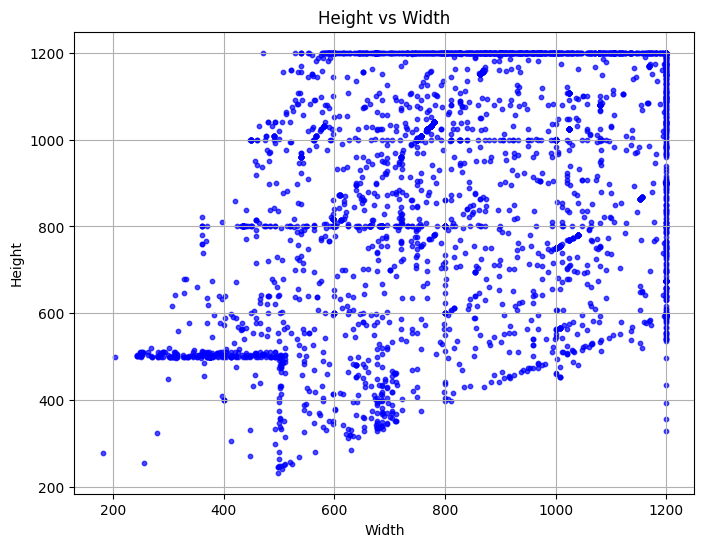

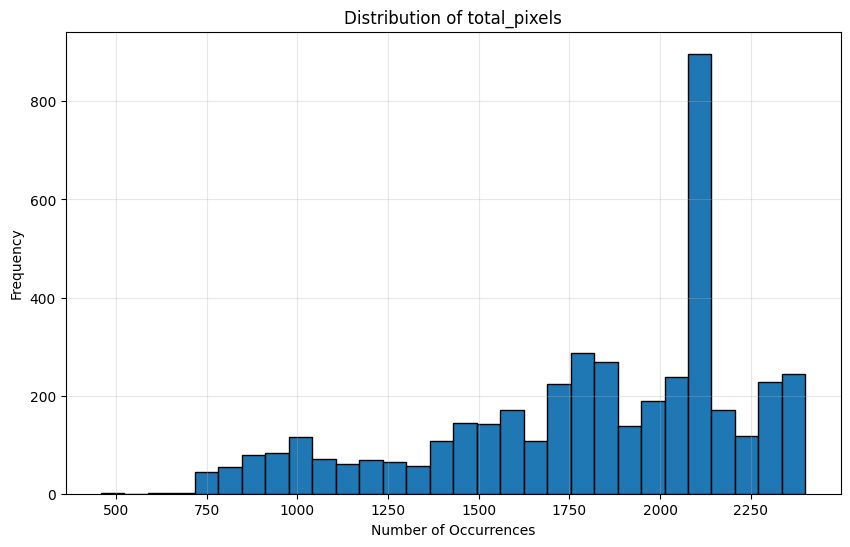

In [40]:
df['total_pixels'].plot(kind='hist', 
                                      bins=30, 
                                      edgecolor='black',
                                      figsize=(10, 6))

# Add labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.title('Distribution of total_pixels')
plt.grid(True, alpha=0.3)

plt.show()

In [10]:
df_list = []

for index in range(0, df.shape[0]):

    temp_df = pd.DataFrame(data=extract_corner_stats(df['array'][index], df['height'][index], df['width'][index]), index=[0,])
    df_list.append(temp_df)

df_corners = pd.concat(df_list)

df = pd.concat([df,df_corners.reset_index(drop=True)], axis=1)

In [11]:
df.head(1)

,item_id,site_id,domain_id,picture_id,correct_background?,img_path,array,height,width,total_pixels,top_left,top_right,bottom_left,bottom_right
0,MLA1131600086,MLA,MLA-BOOTS_AND_BOOTIES,820430-MLA49628611503_042022,0,../data/raw/img/D_820430-MLA49628611503_042022...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1198,1200,2398,"[148.64, 136.92, 131.8]","[146.01, 135.46, 133.48]","[185.5, 182.53, 176.76]","[202.64, 200.98, 195.53]"


The color ranges I defined for pastel and white detection were determined using a combination of color theory principles and empirical RGB analysis of known pastel colors. Here's the technical breakdown of the methodology:

1. Pastel Color Definition Technique
Pastel colors are characterized by:

High Value (Brightness): Achieved by keeping RGB components above ~180

Low Saturation: Created by having similar values across RGB channels

Soft Appearance: Avoids pure primary colors (no 0 or 255 extremes)

Implementation Approach:

Channel Analysis: For each pastel variant (red, blue, etc.), I:

Identified the dominant channel (e.g., red for pastel red)

Set its range slightly higher than other channels (but below 255)

Constrained secondary channels to be within 30-50 points of the dominant channel

In [12]:
# Color ranges in RGB (0-255 scale)
PASTEL_RANGES = {
    'red': ((220, 240), (180, 220), (180, 220)),
    'blue': ((180, 220), (180, 220), (220, 240)),
    'green': ((180, 220), (220, 240), (180, 220)),
    'yellow': ((240, 255), (240, 255), (180, 220)),
    'pink': ((240, 255), (180, 220), (200, 230)),
    'purple': ((200, 230), (180, 220), (220, 240))
}

WHITE_RANGE = {
    'white':((230, 255), (230, 255), (230, 255))
}

In [18]:
import ast

In [24]:
# Process each corner column
for corner in ['top_left', 'top_right', 'bottom_left', 'bottom_right']:
    df[corner] = df[corner].apply(lambda x: ast.literal_eval(x))  
    col_name = f"{corner}_rgb"
    
    # Create pastel checks
    pastel_results = df[corner].apply(
        lambda x: is_that_color(x, PASTEL_RANGES) if isinstance(x, list) else None
    ).apply(pd.Series)

In [27]:
pastel_results.value_counts()

0    
False    4287
True       85
Name: count, dtype: int64

# Parte II

Con el fin de evaluar la solución, se nos hace llegar un nuevo dataset (`productive_data.csv`) con los últimos 5,800 ítems revisados por el equipo de moderadores. La idea en esta parte es que realices una evaluación de tu propuesta y nos hagas saber si estaría lista para puesta en producción. **Nota:** Recuerda que en Mercado Libre trabajamos codo a codo para alcanzar nuestros objetivos así que cualquier duda o solicitud con gusto será atendida por tus compañeros de equipo o stakeholders.

Lo primero es que al revisar el dataset `productive_data.csv` no se encuentran 5.800 ítems, sino 1.627. Para ello procesamos las imágenes de la misma manera que con el entrenamiento: descarga, resizing y remoción de fondos. Luego aplicamos el modelo para predecir sí cumple las políticas de la compañía.

# Parte III

Debido al gran volumen de ítems que procesamos día a día, algún error en nuestras soluciones podría llegar a afectar muchos vendedores y generar malas experiencias de usuario en el marketplace. Con lo cual, solemos penalizar bastante los errores de clasificación que involucren bajas erróneas de ítems. Como última tarea, te proponemos plantear un proceso que nos permita maximizar la precisión de tu solución con base a los datos que tienes disponibles hasta el momento.